In [1]:
import matplotlib.pyplot as plt
import numpy as np

### Notes:

Special points are more accurate, determined using localisation with beacons. This process is time-consuming so special points are taken sporadically.

Localisation only corrects the position of the rover, but NOT ITS ANGLE. So angular error is not corrected.
So during this correction, the rover gets to update its angular position.

The 'initial' points or blue points are determined by wheel odometry. While faster to calculate, wheel error adds up.
Every few blue points, a special point is taken for that last blue point.

The blue points are then corrected so that it fits the special point. The angular position of the robot is also recalibrated as a result. 
Initial points are scaled to fit their special points. Note that this correction is a local map correction, not a global correction.

This is different from usual graph-SLAM, where the correction is global. Although, it would have be nice to run a least-squares optimisation to tweak all blue points to reduce global error. 

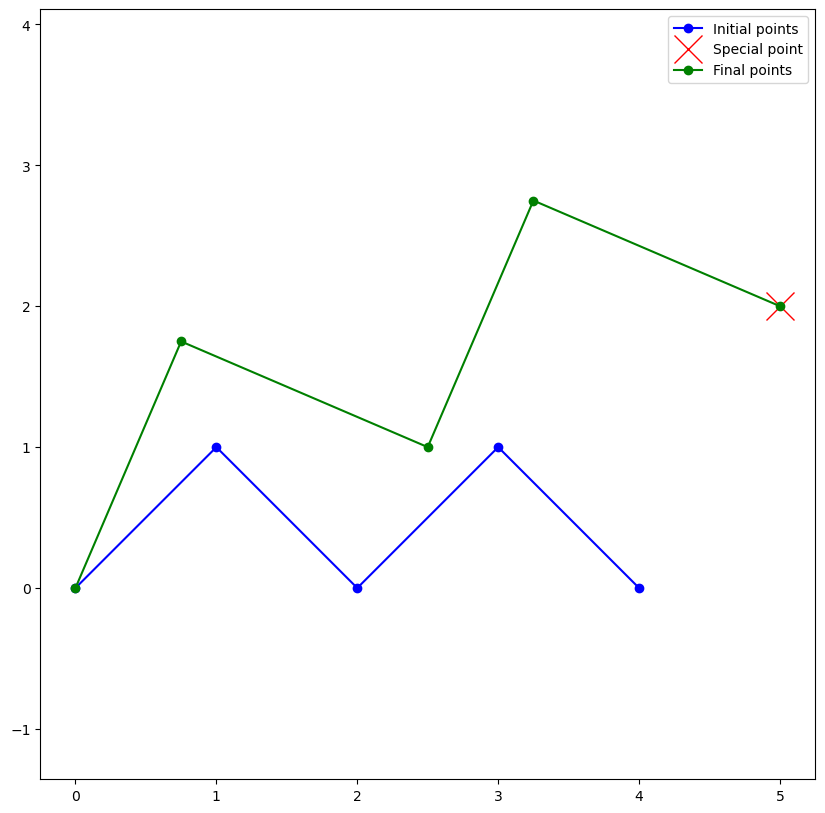

In [4]:


# Define your points and the special point
points = [(0, 0), (1, 1), (2, 0), (3, 1), (4, 0)]
special_point = (5, 2)

# Convert lists to numpy arrays for easier manipulation
points_np = np.array(points)
special_point_np = np.array(special_point)

# Calculate translation vector from the first point of the path to the origin
translate_vector = -points_np[0]

# Apply translation to all points and the special point
translated_points = points_np + translate_vector
translated_special_point = special_point_np + translate_vector

# Calculate scaling factor
scale = np.linalg.norm(translated_special_point) / np.linalg.norm(translated_points[-1])

# Apply scaling to all points
scaled_points = scale * translated_points

# Calculate rotation angle
angle = np.arctan2(translated_special_point[1], translated_special_point[0]) - np.arctan2(scaled_points[-1, 1], scaled_points[-1, 0])

# Construct the rotation matrix
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])

# Apply rotation to all points
final_points = np.dot(scaled_points, rotation_matrix.T)

# Plotting the initial and final points
plt.figure(figsize=(10, 10))
plt.plot(points_np[:, 0], points_np[:, 1], 'bo-', label='Initial points')
plt.plot(special_point_np[0], special_point_np[1], 'rx',label='Special point', markersize=20)
plt.plot(final_points[:, 0], final_points[:, 1], 'go-', label='Final points')
plt.legend()
plt.axis('equal')
plt.show()


/var/folders/1f/rjjb6d_j1nx2wjjbspryf95r0000gn/T/ipykernel_19163/3939265602.py:77: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.linalg.norm(translated_special_point) / \


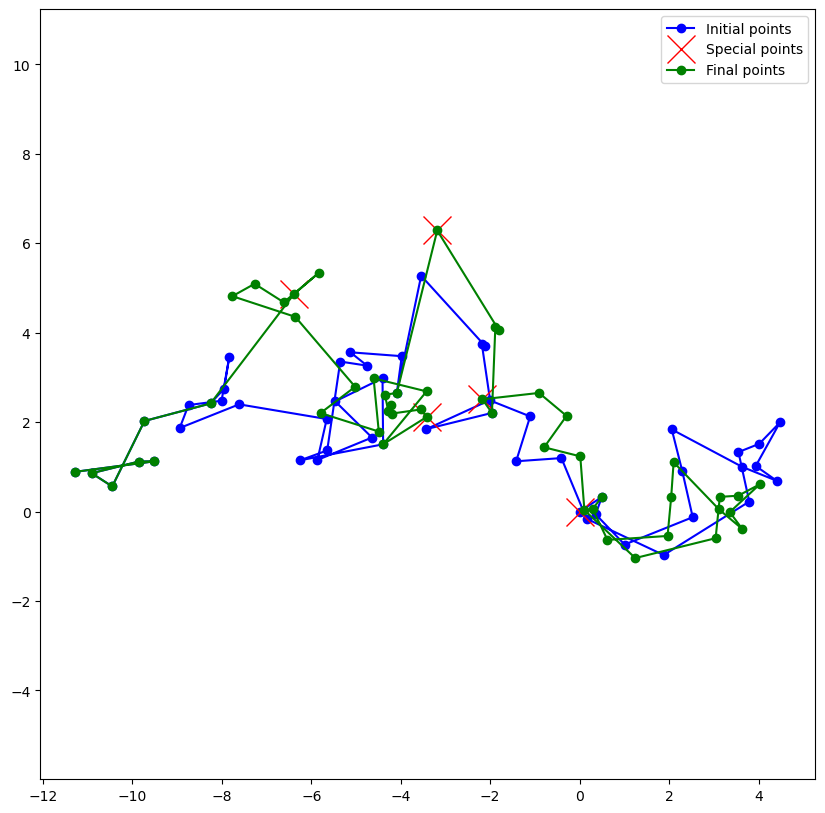

In [1]:
# !pip install simplification;
# !pip install scikit-learn shapely simplification;
# !pip install networkx scipy;
# !pip install yellowbrick;
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

file_name = "data.json"
#########################
# with open(file_name, "r") as file:
#     json_data = file.read()

# # Parse the JSON into a dictionary
# data = json.loads(json_data)

# Extract the lists from the dictionary
# raw_points = data["list1"]
# corrections = data["list2"]

#########################

# Set a random seed for reproducibility
np.random.seed(42)

# Define the number of steps
n_steps = 50

# Generate the steps for x and y directions
dx = np.random.randn(n_steps)
dy = np.random.randn(n_steps)

# Calculate the actual points by cumulatively summing the steps
x = np.cumsum(dx)
y = np.cumsum(dy)


# Combine x and y into an array of points
raw_points = list(zip(x, y))
# add (0,0) to front of list
raw_points.insert(0, (0, 0))

corrections = [(0, 0, 0)]

for v in [20, 24, 31, 43]:
    corrections.append(
        (v, raw_points[v][0]+np.random.uniform(0, 3), raw_points[v][1]+np.random.uniform(0, 3)))


#########################
# Convert lists to numpy arrays for easier manipulation
points_np = np.array(raw_points)
special_points_np = np.array(corrections)

# Sort special points by index
special_points_np = special_points_np[special_points_np[:, 0].argsort()]

distorted_points = []
prev_idx = 0

# Process each special point
for special_point in special_points_np:
    idx, x, y = special_point

    # Get the points up to the current index
    path_points = points_np[prev_idx:int(idx)+1].copy()

    # Calculate translation vector from the first point of the path to the origin
    translate_vector = -path_points[0]

    # Apply translation to all points and the special point
    translated_points = path_points + translate_vector
    translated_special_point = np.array([x, y]) + translate_vector

    # Calculate scaling factor
    scale = np.linalg.norm(translated_special_point) / \
        np.linalg.norm(translated_points[-1])

    # Apply scaling to all points
    scaled_points = scale * translated_points

    # Calculate rotation angle
    angle = np.arctan2(translated_special_point[1], translated_special_point[0]) - np.arctan2(
        scaled_points[-1, 1], scaled_points[-1, 0])

    # Construct the rotation matrix
    rotation_matrix = np.array(
        [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])

    # Apply rotation to all points
    final_points = np.dot(scaled_points, rotation_matrix.T)

    # Append final points to distorted points, adjusting for translation
    distorted_points.extend(final_points - translate_vector)

    # Update previous index
    prev_idx = int(idx) + 1

# Add any remaining points that were not distorted
distorted_points.extend(points_np[prev_idx:])

# Plotting the initial and final points
plt.figure(figsize=(10, 10))
plt.plot(np.array(raw_points)[:, 0], np.array(
    raw_points)[:, 1], 'bo-', label='Initial points')
plt.plot(np.array(special_points_np)[:, 1], np.array(special_points_np)[
         :, 2], 'rx', markersize=20, label='Special points')
plt.plot(np.array(distorted_points)[:, 0], np.array(
    distorted_points)[:, 1], 'go-', label='Final points')
plt.legend()
plt.axis('equal')
plt.show()
